# Pattern processing

The raw EBSD signal can be empirically evaluated as a superposition of a Kikuchi
diffraction pattern and a smooth background intensity. For pattern indexing, the
latter intensity is usually undesirable, while for [virtual backscatter electron
(VBSE) imaging](virtual_backscatter_electron_imaging.rst), this intensity
can reveal topographical, compositional or diffraction contrast. This section
details methods to enhance the Kikuchi diffraction pattern and manipulate
detector intensities in patterns in an [EBSD](reference.rst#kikuchipy.signals.EBSD)
signal.

Most of the methods operating on EBSD objects use functions that operate on the
individual patterns (`numpy.ndarray`). These single pattern functions are
available in the [kikuchipy.pattern](reference.rst#pattern) module.

Let's import necessary libraries and read the Nickel EBSD data set:

In [1]:
# exchange inline for qt5 for interactive plotting, from the pyqt package
%matplotlib inline

import os
import matplotlib.pyplot as plt
import numpy as np
import kikuchipy as kp


datadir = "../kikuchipy_data/ni/nordif"
s = kp.load(os.path.join(datadir, "Pattern.dat"))

/home/hakon/miniconda3/envs/kp-dev/lib/python3.8/site-packages/pyUSID/viz/__init__.py:16: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  warn('Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. '


Most methods operate inplace (indicated in their docstrings), meaning they
overwrite the patterns in the EBSD signal. If we instead want to keep the
original signal and operate on a new signal, we can create a
[deepcopy](http://hyperspy.org/hyperspy-doc/current/api/hyperspy.signal.html#hyperspy.signal.BaseSignal.deepcopy)
of the original signal. As an example here, we create a new EBSD signal from a
small part of the original signal:

In [2]:
y0, x0 = (77, 156)  # Upper left
y1, x1 = (80, 159)  # Lower right
s2 = s.inav[x0:x1, y0:y1].deepcopy()  # Navigation space slicing
np.may_share_memory(s.data, s2.data)

False

---

## Background correction

### Remove the static background

Effects which are constant, like hot pixels or dirt on the detector, can be
removed by either subtracting or dividing by a static background via
[remove_static_background()](reference.rst#kikuchipy.signals.EBSD.remove_static_background):

Removing the static background:
[########################################] | 100% Completed |  0.4s


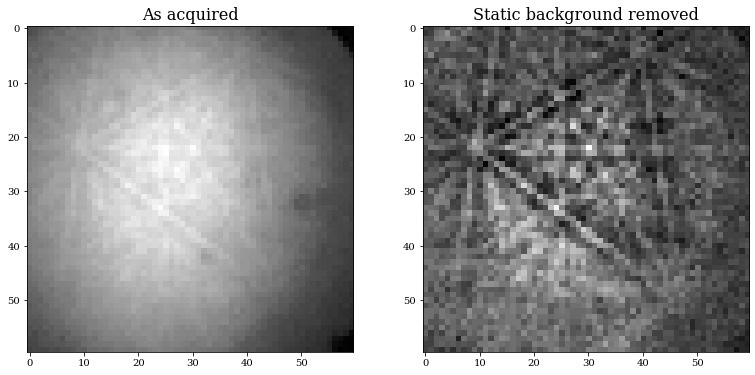

In [3]:
s2.remove_static_background(operation="subtract", relative=True)

_, ax = plt.subplots(figsize=(13, 6), ncols=2)
ax[0].imshow(s.inav[x0, y0].data, cmap="gray")
ax[0].set_title("As acquired", fontsize=16)
ax[1].imshow(s2.inav[0, 0].data, cmap="gray")
ax[1].set_title("Static background removed", fontsize=16);

Here, the static background pattern is assumed to be stored as part of the
signal `metadata`, which can be loaded via
[set_experimental_parameters()](reference.rst#kikuchipy.signals.EBSD.set_experimental_parameters).
The static background pattern can also be passed to the `static_bg` parameter.
Passing `relative=True` (default) ensures that relative intensities between
patterns are kept when they are rescaled after correction to fill the available
data range. In this case, for a scan of data type `uint8` with data range
[0, 255], the highest pixel intensity in a scan is stretched to 255 (and the
lowest to 0), while the rest is rescaled keeping relative intensities between
patterns. With `relative=False`, all patterns are stretched to [0, 255].

The static background pattern intensities can be rescaled to each individual
pattern's intensity range before removal by passing `scale_bg=True`, which
will result in the relative intensity between patterns to be lost (passing
`relative=True` along with `scale_bg=True` is not allowed).

### Remove the dynamic background

Uneven intensity in a static background subtracted pattern can be corrected by
subtracting or dividing by a dynamic background obtained by Gaussian blurring.
This so-called flat fielding is done with
[remove_dynamic_background()](#reference.rst#kikuchipy.signals.EBSD.remove_dynamic_background).
A Gaussian window with a standard deviation set by `std` is used to blur each
pattern individually (dynamic) either in the spatial or frequency domain, set by
`filter_domain`. Blurring in the frequency domain is effectively accomplished
by a low-pass :ref:`Fast Fourier Transform (FFT) filter <fft-filtering>`. The
individual Gaussian blurred dynamic backgrounds are then subtracted or divided
from the respective patterns, set by `operation`:

Removing the dynamic background:
[########################################] | 100% Completed |  0.4s


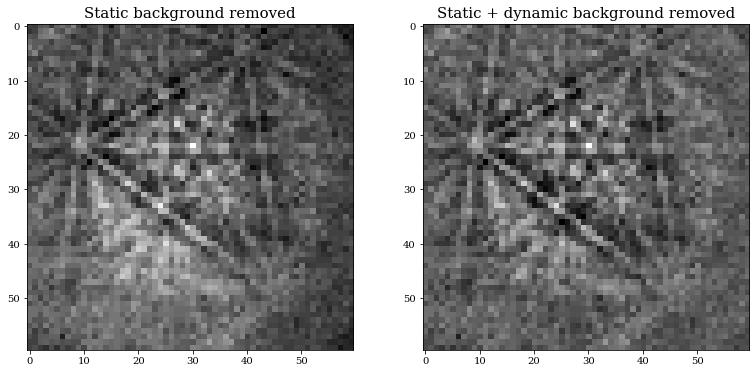

In [4]:
s3 = s2.deepcopy()
s3.remove_dynamic_background(
    operation="subtract",  # Default
    filter_domain="frequency",  # Default
    std=8,  # Default is 1/8 of the pattern width
    truncate=4,  # Default
)

_, ax = plt.subplots(figsize=(13, 6), ncols=2)
ax[0].imshow(s2.inav[0, 0].data, cmap="gray")
ax[0].set_title("Static background removed", fontsize=15)
ax[1].imshow(s3.inav[0, 0].data, cmap="gray")
ax[1].set_title("Static + dynamic background removed", fontsize=15);

The width of the Gaussian window is truncated at the `truncated` number of
standard deviations. Output patterns are rescaled to fill the input patterns'
data type range.

---
## Get the dynamic background

The Gaussian blurred pattern removed during dynamic background correction can
be obtained as an EBSD signal by calling
[get_dynamic_background()](reference.rst#kikuchipy.signals.EBSD.get_dynamic_background):

Getting the dynamic background:
[########################################] | 100% Completed |  0.1s


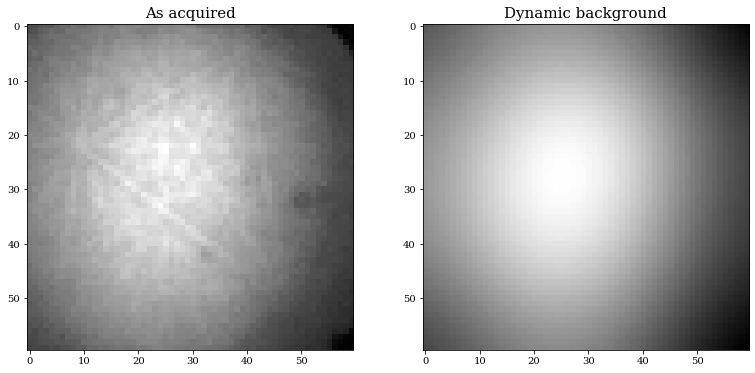

In [5]:
bg = s.inav[x0:x1, y0:y1].get_dynamic_background(
    filter_domain="frequency", std=8, truncate=4
)
bg

_, ax = plt.subplots(figsize=(13, 6), ncols=2)
ax[0].imshow(s.inav[x0, y0].data, cmap="gray")
ax[0].set_title("As acquired", fontsize=15)
ax[1].imshow(bg.inav[0, 0].data, cmap="gray")
ax[1].set_title("Dynamic background", fontsize=15);

---
## Average neighbour patterns

The signal-to-noise ratio in patterns in an EBSD signal `s` can be improved by
averaging patterns with their closest neighbours within a window/kernel/mask
with
[average_neighbour_patterns()](reference.rst#kikuchipy.signals.EBSD.average_neighbour_patterns):

Averaging with the neighbour patterns:
[########################################] | 100% Completed |  0.1s


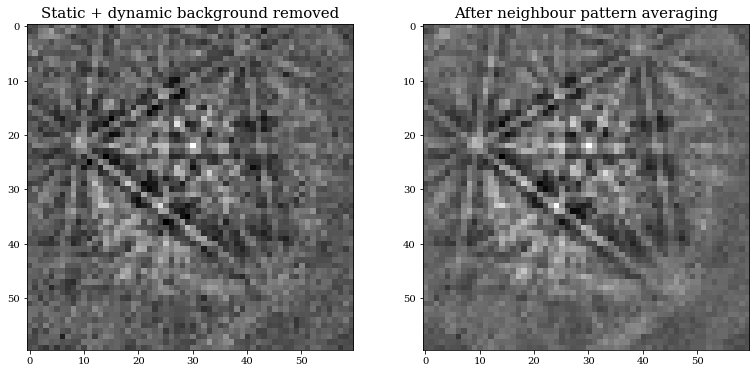

In [6]:
s4 = s3.deepcopy()
s4.average_neighbour_patterns(window="gaussian", std=1)

_, ax = plt.subplots(figsize=(13, 6), ncols=2)
ax[0].imshow(s3.inav[0, 0].data, cmap="gray")
ax[0].set_title("Static + dynamic background removed", fontsize=15)
ax[1].imshow(s4.inav[0, 0].data, cmap="gray")
ax[1].set_title("After neighbour pattern averaging", fontsize=15);

The array of averaged patterns $g(n_{\mathrm{x}}, n_{\mathrm{y}})$ is obtained
by spatially correlating a window $w(s, t)$ with the array of patterns
$f(n_{\mathrm{x}}, n_{\mathrm{y}})$, here 4D, which is padded with zeros at the
edges. As coordinates $n_{\mathrm{x}}$ and $n_{\mathrm{y}}$ are varied, the
window origin moves from pattern to pattern, computing the sum of products of
the window coefficients with the neighbour pattern intensities, defined by the
window shape, followed by normalizing by the sum of the window coefficients. For
a symmetrical window of shape $m \times n$, this becomes [Gonzalez2017]_

\begin{equation}
    g(n_{\mathrm{x}}, n_{\mathrm{y}}) =
    \frac{\sum_{s=-a}^a\sum_{t=-b}^b{w(s, t)
    f(n_{\mathrm{x}} + s, n_{\mathrm{y}} + t)}}
    {\sum_{s=-a}^a\sum_{t=-b}^b{w(s, t)}},
\end{equation}

where $a = (m - 1)/2$ and $b = (n - 1)/2$. The window $w$, a [Window](reference.rst#kikuchipy.filters.window.Window) object, can be plotted:

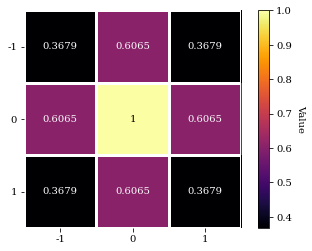

In [7]:
w = kp.filters.Window(window="gaussian", shape=(3, 3), std=1)
_, _, _ = w.plot(cmap="inferno")

Any 1D or 2D window with desired coefficients can be used. This custom window
can be passed to the `window` parameter in
[average_neighbour_patterns()](reference.rst#kikuchipy.signals.EBSD.average_neighbour_patterns)
or [Window](reference.rst#kikuchipy.filters.window.Window) as a `numpy.ndarray`
or a `dask.array.Array`. Additionally, any window in
[scipy.signal.windows.get_window](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html) passed as a string via `window` with the
necessary parameters as keyword arguments (like `std=1` for `window="gaussian"`)
can be used. To demonstrate the creation and use of an asymmetrical circular
window (and the use of [make_circular()](reference.rst#kikuchipy.filters.window.Window.make_circular), although we could
create a circular window directly by calling `window="circular"` upon window
initialization):

In [8]:
w = kp.filters.Window(window="rectangular", shape=(5, 4))
w

Window (5, 4) rectangular
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]

In [9]:
w.make_circular()
w

Window (5, 4) circular
[[0. 0. 1. 0.]
 [0. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 1. 1. 1.]
 [0. 0. 1. 0.]]

In [10]:
s5 = s3.deepcopy()
s5.average_neighbour_patterns(w)

Averaging with the neighbour patterns:
[########################################] | 100% Completed |  0.1s


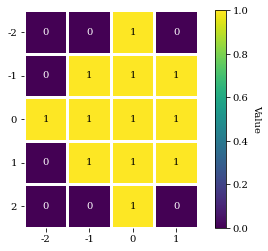

In [11]:
fig, im, cbar = w.plot()

<div class="alert alert-info">
    Note
    
    Neighbour pattern averaging increases the virtual interaction volume of the
    electron beam with the sample, leading to a potential loss in spatial
    resolution. Averaging may in some cases, like on grain boundaries, mix two
    or more different diffraction patterns, which might be unwanted. See
    [Wright2015]_ for a discussion of this concern.
</div>

---
## Adaptive histogram equalization

Enhancing the pattern contrast with adaptive histogram equalization has been
found useful when comparing patterns for dictionary indexing [Marquardt2017]_.
With [adaptive_histogram_equalization()](reference.rst#kikuchipy.signals.EBSD.adaptive_histogram_equalization), the
intensities in the pattern histogram are spread to cover the available range,
e.g. [0, 255] for patterns of `uint8` data type:

Adaptive histogram equalization:
[########################################] | 100% Completed |  0.1s


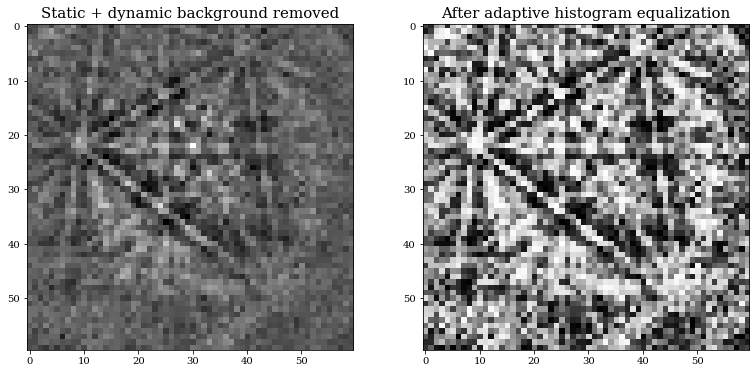

In [12]:
s6 = s3.deepcopy()
s6.adaptive_histogram_equalization(kernel_size=(15, 15))

_, ax = plt.subplots(figsize=(13, 6), ncols=2)
ax[0].imshow(s3.inav[0, 0].data, cmap="gray")
ax[0].set_title("Static + dynamic background removed", fontsize=15)
ax[1].imshow(s6.inav[0, 0].data, cmap="gray")
ax[1].set_title("After adaptive histogram equalization", fontsize=15);

The `kernel_size` parameter determines the size of the contextual regions. See
e.g. Fig. 5 in [Jackson2019]_, also available via [EMsoft's GitHub repository
wiki](https://github.com/EMsoft-org/EMsoft/wiki/DItutorial#52-determination-of-pattern-pre-processing-parameters), for the effect of varying `kernel_size`.

---
## Filtering in the frequency domain

Filtering of patterns in the frequency domain can be done with
[fft_filter()](reference.rst#kikuchipy.signals.EBSD.fft_filter). This method
takes a spatial kernel defined in the spatial domain, or a transfer function
defined in the frequency domain, in the `transfer_function` argument as a
`numpy.ndarray` or a [Window](reference.rst#kikuchipy.filters.window.Window).
Which domain the transfer function is defined in must be passed to the
`function_domain` argument. Whether to shift zero-frequency components to the
centre of the FFT can also be controlled via `shift`, but note that this is
only used when `function_domain="frequency"`.

Popular uses of filtering of EBSD patterns in the frequency domain include
removing large scale variations across the detector with a Gaussian high pass
filter, or removing high frequency noise with a Gaussian low pass filter. These
particular functions are readily available via
[Window](reference.rst#kikuchipy.filters.window.Window):

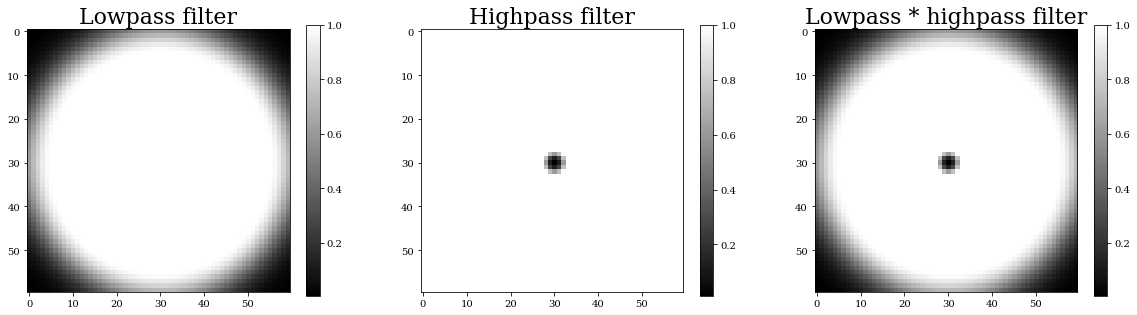

In [13]:
pattern_shape = s.axes_manager.signal_shape[::-1]
w_low = kp.filters.Window(
    window="lowpass",
    cutoff=25,
    cutoff_width=10,
    shape=pattern_shape
)
w_high = kp.filters.Window(
    window="highpass",
    cutoff=3,
    cutoff_width=2,
    shape=pattern_shape
)

fig, ax = plt.subplots(figsize=(20, 5), ncols=3)
im0 = ax[0].imshow(w_low, cmap="gray")
ax[0].set_title("Lowpass filter", fontsize=22)
fig.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(w_high, cmap="gray")
ax[1].set_title("Highpass filter", fontsize=22)
fig.colorbar(im1, ax=ax[1])
im2 = ax[2].imshow(w_low * w_high, cmap="gray")
ax[2].set_title("Lowpass * highpass filter", fontsize=22)
fig.colorbar(im2, ax=ax[2]);

Then, to multiply the FFT of each pattern with this transfer function, and
subsequently computing the inverse FFT (IFFT), we use
[fft_filter()](reference.rst#kikuchipy.signals.EBSD.fft_filter), and remember to
shift the zero-frequency components to the centre of the FFT:

FFT filtering:
[########################################] | 100% Completed |  0.2s


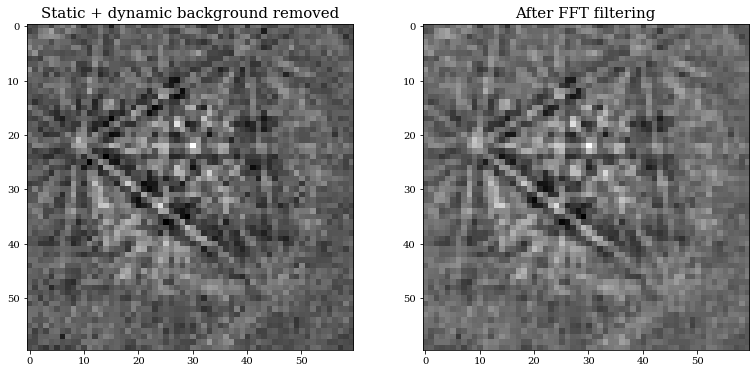

In [14]:
s7 = s3.deepcopy()
s7.fft_filter(
    transfer_function=w_low * w_high,
    function_domain="frequency",
    shift=True
)

_, ax = plt.subplots(figsize=(13, 6), ncols=2)
ax[0].imshow(s3.inav[0, 0].data, cmap="gray")
ax[0].set_title("Static + dynamic background removed", fontsize=15)
ax[1].imshow(s7.inav[0, 0].data, cmap="gray")
ax[1].set_title("After FFT filtering", fontsize=15);

Note that filtering with a spatial kernel in the frequency domain, after
creating the kernel's transfer function via FFT, and computing the inverse FFT
(IFFT), is, in this case, the same as spatially correlating the kernel with the
pattern.

Let's demonstrate this by attempting to sharpen a pattern with a Laplacian
kernel in both the spatial and frequency domains and comparing the results
(this is a purely illustrative example, and perhaps not that practically
useful):

In [15]:
s8 = s3.deepcopy()
w_laplacian = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
s8.fft_filter(transfer_function=w_laplacian, function_domain="spatial")

FFT filtering:
[########################################] | 100% Completed |  0.1s


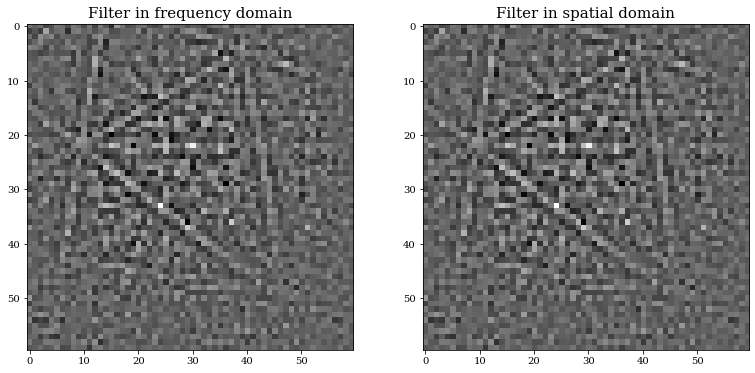

In [16]:
from scipy.ndimage import correlate


p_filt = correlate(s3.inav[1, 0].data.astype(np.float32), weights=w_laplacian)
p_filt_resc = kp.pattern.rescale_intensity(p_filt, dtype_out=np.uint8)

_, ax = plt.subplots(figsize=(13, 6), ncols=2)
ax[0].imshow(s8.inav[1, 0].data, cmap="gray")
ax[0].set_title("Filter in frequency domain", fontsize=15)
ax[1].imshow(p_filt_resc, cmap="gray")
ax[1].set_title("Filter in spatial domain", fontsize=15)

np.sum(s8.inav[1, 0].data - p_filt_resc);

Note also that [fft_filter()](reference.rst#kikuchipy.signals.EBSD.fft_filter)
performs the filtering on the patterns with data type `np.float32`, and
therefore have to rescale back to the pattern's original data type if necessary.

---
## Rescale intensity

Vendors usually write patterns to file with 8 (``uint8``) or 16 (``uint16``) bit
integer depth, holding [0, 2$^8$] or [0, 2$^{16}$] gray levels, respectively. To
avoid losing intensity information when processing, we often change data types
to e.g. 32 bit floating point (``float32``). However, only changing the data
type with [change_dtype](http://hyperspy.org/hyperspy-doc/current/api/hyperspy.signal.html#hyperspy.signal.BaseSignal.change_dtype) does not
rescale pattern intensities, leading to patterns not using the full available
data type range:

uint8 255
uint16 255


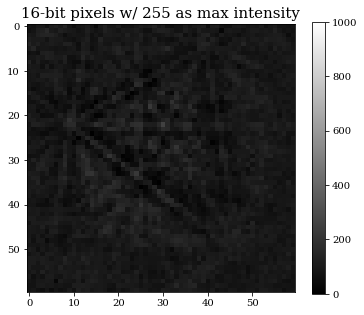

In [17]:
s9 = s3.deepcopy()

print(s9.data.dtype, s9.data.max())

s9.change_dtype(np.uint16)

print(s9.data.dtype, s9.data.max())

plt.figure(figsize=(6, 5))
plt.imshow(s9.inav[0, 0].data, vmax=1000, cmap="gray")
plt.title("16-bit pixels w/ 255 as max intensity", fontsize=15)
plt.colorbar();

In these cases it is convenient to rescale intensities to a desired data type
range, either keeping relative intensities between patterns in a scan or not. We
can do this for all patterns in an EBSD signal with
[kikuchipy.signals.EBSD.rescale_intensity()](reference.rst#kikuchipy.signals.EBSD.rescale_intensity):

Rescaling the image intensities:
[########################################] | 100% Completed |  0.3s
uint16 65535


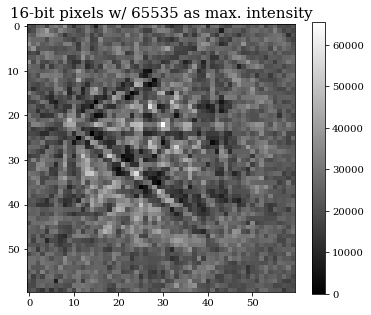

In [18]:
s9.rescale_intensity(relative=True)

print(s9.data.dtype, s9.data.max())

plt.figure(figsize=(6, 5))
plt.imshow(s9.inav[0, 0].data, cmap="gray")
plt.title("16-bit pixels w/ 65535 as max. intensity", fontsize=15)
plt.colorbar();

Or, we can do it for a single pattern (`numpy.ndarray`) with
[kikuchipy.pattern.rescale_intensity()](reference.rst#kikuchipy.pattern.rescale_intensity):

In [19]:
p = s3.inav[0, 0].data
print(p.min(), p.max())
p2 = kp.pattern.rescale_intensity(p, dtype_out=np.uint16)
print(p2.min(), p2.max())

0 255
0 65535


We can also stretch the pattern contrast by removing intensities outside a range
passed to `in_range` or at certain percentiles by passing percents to
`percentiles`:

In [20]:
s10 = s3.deepcopy()
s10.rescale_intensity(in_range=(5, 250))
print(s10.data.min(), s10.data.max())

Rescaling the image intensities:
[########################################] | 100% Completed |  0.3s
0 255


In [21]:
s10.rescale_intensity(percentiles=(0.5, 99.5))
print(s10.data.min(), s3.data.max())

Rescaling the image intensities:
[########################################] | 100% Completed |  0.1s
0 255


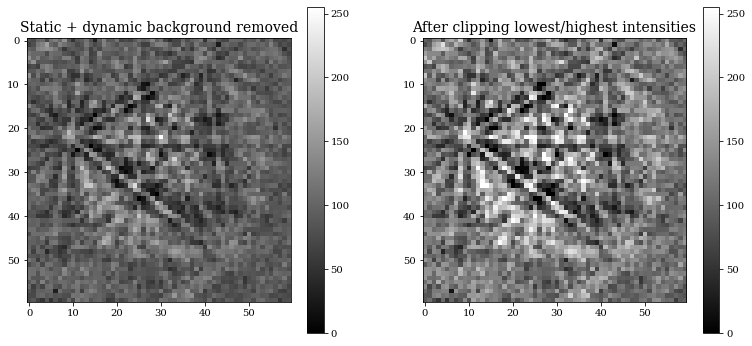

In [22]:
fig, ax = plt.subplots(figsize=(13, 6), ncols=2)
im0 = ax[0].imshow(s3.inav[0, 0].data, cmap="gray")
ax[0].set_title("Static + dynamic background removed", fontsize=14)
fig.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(s10.inav[0, 0].data, cmap="gray")
ax[1].set_title("After clipping lowest/highest intensities", fontsize=14)
fig.colorbar(im1, ax=ax[1]);

This can reduce the influence of outliers with exceptionally high or low
intensities, like hot or dead pixels.

---
## Normalize intensity

It can be useful to normalize pattern intensities to a mean value of $\mu = 0.0$
and a standard deviation of e.g. $\sigma = 1.0$ when e.g. comparing patterns or
calculating the :ref:`image quality <image-quality>`. Patterns can be normalized
with
[normalize_intensity()](reference.rst#kikuchipy.signals.EBSD.normalize_intensity):

In [23]:
s11 = s3.deepcopy()
np.mean(s11.data)

109.73453703703704

In [24]:
# s11.change_dtype(np.float32)  # Or pass `dtype_out` as below
s11.normalize_intensity(num_std=1, dtype_out=np.float32)
np.mean(s11.data)

Normalizing the image intensities:
[########################################] | 100% Completed |  0.4s


3.485032e-08

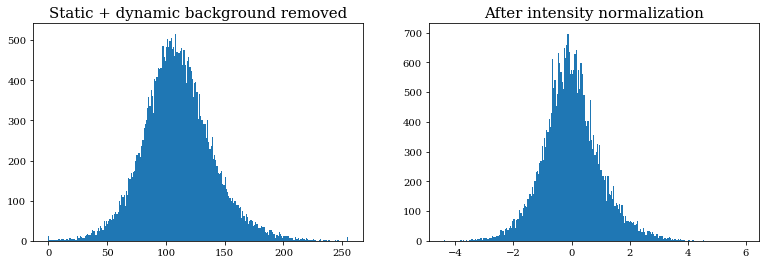

In [25]:
_, ax = plt.subplots(figsize=(13, 4), ncols=2)
_ = ax[0].hist(s3.data.ravel(), bins=255)
ax[0].set_title("Static + dynamic background removed", fontsize=15)
_ = ax[1].hist(s11.data.ravel(), bins=255)
ax[1].set_title("After intensity normalization", fontsize=15);